<a href="https://colab.research.google.com/github/kle-hauzenberg/assignment5-xlstm/blob/main/A5_Hauzenberger_COLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5: Extended Long Short-Term Memory (xLSTM)

*Author:* Philipp Seidl

*Copyright statement:* This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for  personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

In this assignment, we will explore the xLSTM architecture, a novel extension of the classic LSTM model. The paper can be found here: https://arxiv.org/abs/2405.04517

## Background
Recurrent Neural Networks (RNNs), particularly LSTMs, have proven highly effective in various sequence modeling tasks. However, the emergence of Transformers, with their parallel processing capabilities, has shifted the focus away from LSTMs, especially in large-scale language modeling.
The xLSTM architecture aims to bridge this gap by enhancing LSTMs with mechanisms inspired by modern LLMs (e.g. block-strucutre, residual connections, ...).  Further it introduces:
- Exponential gating with normalization and stabilization techniques, which improves gradient flow and memory capacity.
- Modifications to the LSTM memory structure, resulting in two variants:
    - sLSTM: Employs a scalar memory with a scalar update rule and a new memory mixing technique through recurrent connections.
    - mLSTM: Features a matrix memory, employs a covariance update rule, and is fully parallelizable, making it suitable for scaling.

By integrating these extensions into residual block backbones, xLSTM blocks are formed, which can then be residually stacked to create complete xLSTM architectures.

## Exercise 1: Environment Setup

When working with new architectures or specialized frameworks, it's essential to correctly set up the environment to ensure reproducability. This exercise focuses on setting up the environment for working with the `xlstm` repository.

1. Visit and clone the official repository: [https://github.com/NX-AI/xlstm](https://github.com/NX-AI/xlstm).  
2. Set up the environment  
3. Document your setup:  
   - OS, Python version, Environment setup, CUDA version (if applicable), and GPU details.  
   - Note any challenges you faced and how you resolved them.
4. Submit your setup as a bash script using the IPython `%%bash` magic. Ensure it is reproducible.

Getting mLSTM working only is fine (if you encounter issues with sLSTM cuda kernels)

> **Note**: Depending on your system setup, you may need to adjust the `environment_pt220cu121.yaml` file, such as for the CUDA version. For this assignment, it is recommended to run it on GPUs. If you don't have one, consider using  [Colab](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true) or other online resources.

> **Recommendations**: While the repository suggests using `conda`, we recommend using `mamba` or `micromamba` instead (way faster) (except if you are using colab). Learn more about them here: [https://mamba.readthedocs.io/en/latest/index.html](https://mamba.readthedocs.io/en/latest/index.html).

In [2]:
%%bash

# Install the specific version of xlstm directly from GitHub
pip install git+https://github.com/NX-AI/xlstm@79e463c84cd8bb839bb9a7d81138f1a0184c68a1 2>/dev/null

# Install additional required packages directly into Colab
pip install omegaconf
pip install dacite
pip install torchmetrics
pip install ninja

# Clone the GitHub repository that includes the data and the database of
# hyperparameter experiments
DATA_REPO_URL="https://github.com/kle-hauzenberg/assignment5-xlstm.git"
DATA_REPO_NAME="assignment5-xlstm"
echo "Cloning the data repository..."
if [ -d "$DATA_REPO_NAME" ]; then
    echo "  Repository already exists. Skip cloning."
else
    git clone $DATA_REPO_URL $DATA_REPO_NAME 2>/dev/null
fi

# Documenting environment details
echo "Documenting environment setup..."
OS=$(uname -s)
PYTHON=$(python --version)
GPU=$(system_profiler SPDisplaysDataType 2>/dev/null | grep "Chip" || echo "No GPU detected")

FILENAME="/content/assignment5-xlstm/environment_setup.txt"
echo -e "Environment setup details:\n" > "$FILENAME"
echo "Operating System: $OS" >> "$FILENAME"
echo "Python Version: $PYTHON" >> "$FILENAME"
echo "GPU Details: $GPU" >> "$FILENAME"

wait
echo "Setup complete. Details logged in "$FILENAME"."


  Cloning https://github.com/NX-AI/xlstm (to revision 79e463c84cd8bb839bb9a7d81138f1a0184c68a1) to /tmp/pip-req-build-jtuf74rr
  Resolved https://github.com/NX-AI/xlstm to commit 79e463c84cd8bb839bb9a7d81138f1a0184c68a1
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Cloning the data repository...
  Repository already exists. Skip cloning.
Documenting environment setup...
Setup complete. Details logged in /content/assignment5-xlstm/environment_setup.txt.


In [3]:
# Verify your installation of xLSTM:
from omegaconf import OmegaConf
from dacite import from_dict
from dacite import Config as DaciteConfig
from xlstm import xLSTMBlockStack, xLSTMBlockStackConfig
import os
import torch

DEVICE = "cuda" if torch.cuda.is_available() else 'cpu'

use_slstm_kernels = True # set to True if you want to check if sLSTM cuda kernels are working

xlstm_cfg = f"""
mlstm_block:
  mlstm:
    conv1d_kernel_size: 4
    qkv_proj_blocksize: 4
    num_heads: 4
slstm_block:
  slstm:
    backend: {'cuda' if use_slstm_kernels else 'vanilla'}
    num_heads: 4
    conv1d_kernel_size: 4
    bias_init: powerlaw_blockdependent
  feedforward:
    proj_factor: 1.3
    act_fn: gelu
context_length: 32
num_blocks: 2 #7
embedding_dim: 64
slstm_at: [1] # empty = mLSTM only
"""
cfg = OmegaConf.create(xlstm_cfg)
cfg = from_dict(data_class=xLSTMBlockStackConfig, data=OmegaConf.to_container(cfg),
                config=DaciteConfig(strict=True))
xlstm_stack = xLSTMBlockStack(cfg)

x = torch.randn(4, 32, 64).to(DEVICE)
xlstm_stack = xlstm_stack.to(DEVICE)
y = xlstm_stack(x)
y.shape == x.shape

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_H

Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py310_cu121/slstm_HS64BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/slstm_HS64BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slstm_HS64BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module slstm_HS64BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
/usr/local/lib/python3.10/dist-p

True

## Exercise 2: Understanding xLSTM Hyperparameters
Explain key hyperparameters that influence the performance and behavior of the xLSTM architecture and explain how they influence total parameter count.
The explanation should include: proj_factor, num_heads, act_fn, context_length, num_blocks, embedding_dim, hidden_size, dropout, slstm_at, qkv_proj_blocksize, conv1d_kernel_size. Also include how the matrix memory size of mLSTM is determined.

To get a better grasp of the xLSTM architecture, I rewrite its equation in vectorized from with a focus on the dimensions of the cell inputs, the (learnable) weight matices and other parameters, and the cell outputs. Another focus is on the additional features that are not directly part of the sub-architectures of the mLSTM and sLSTM blocks: normalization, post and pre up-projection, convolution layers.

**Layer normalization.** We apply layer normalization at different places in the model. First, on the inputs to each mLSTM and sLSTM layer. The size of the inputs are defined by the embedding dimension (which encodes semantic information about input elements). Second, but here I am not precise, after each mLSTM and sLSTM cell and after a xLSTM block (just want to mention it here for completness sake). In every case, each layer normalization has **two trainable parameters** (scale and shift).

The **sLSTM** in vectorized form with input tensor $\mathbf{x}_t$:
$$\begin{align*}
\tilde{\mathbf{x}}_t &= \theta\left((\mathbf{x}_t,\mathbf{x}_{t-1},\ldots\mathbf{x}_{t-p})\mathbf{w}_x\right) & \text{causal convolution with }p\text{ lags: }(D\times 1)  \\
\mathbf{z}_t &= \varphi\left(\mathbf{W}_z\tilde{\mathbf{x}}_t + \mathbf{R}_z\mathbf{h}_{t-1} + \mathbf{b}_z \right) & \text{cell input: }(D\times 1) \\
\mathbf{i}_t &= \exp\left(\mathbf{W}_i\tilde{\mathbf{x}}_t + \mathbf{R}_i\mathbf{h}_{t-1} + \mathbf{b}_i \right) & \text{input gate: }(D\times 1) \\
\mathbf{f}_t &= \sigma\left(\mathbf{W}_f\tilde{\mathbf{x}}_t + \mathbf{R}_f\mathbf{h}_{t-1} + \mathbf{b}_f \right) & \text{forget gate: }(D\times 1) \\
\mathbf{o}_t &= \sigma\left(\mathbf{W}_o\tilde{\mathbf{x}}_t + \mathbf{R}_o\mathbf{h}_{t-1} + \mathbf{b}_o \right) & \text{output gate: }(D\times 1) \\
\mathbf{c}_t &= \mathbf{f}_t \odot \mathbf{c}_{t-1} + \mathbf{i}_t \odot \mathbf{z}_t  & \text{cell state: }(D\times 1)\\
\mathbf{n}_t &= \mathbf{f}_t \odot \mathbf{n}_{t-1} + \mathbf{i}_t & \text{normalizer state: }(D\times 1) \\
\mathbf{h}_t &= \mathbf{o}_t \odot \left(\mathbf{c}_t \odot \mathbf{n}_t^{-1}\right) & \text{hidden state: }(D\times 1)
\end{align*}
$$


## Exercise 3: Train an xLSTM model on the Trump Dataset from the previous exercise
Your task is to train an xLSTM model on the Trump Dataset from the previous exercise.
- The goal is to achieve an average validation loss $\mathcal{L}_{\text{val}} < 1.35$.
- You do not need to perform an extensive hyperparameter search, but you should document your runs. Log your runs with used hyperparameters using tools like wandb, neptune, mlflow, ... or a similar setup. Log training/validation loss and learning rate over steps as well as total trainable parameters of the model for each run.
- You can use the training setup from the previous exercises or any setup of your choice using high level training libaries.

In [4]:
import re
import requests
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchmetrics
import torchmetrics.classification as classification
from dacite import from_dict
from xlstm.xlstm_lm_model import xLSTMLMModel, xLSTMLMModelConfig
from omegaconf import DictConfig, OmegaConf
from torchmetrics import Metric
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import time
import pickle
import sqlite3

class Encoder:
    def __init__(self, alphabet: str):
        # Define the alphabet and create a mapping from characters to integers and back
        self.alphabet = alphabet
        self.char_to_idx = {char: idx for idx, char in enumerate(alphabet)}
        self.idx_to_char = {idx: char for idx, char in enumerate(alphabet)}
        # Build the regex pattern from the alphabet
        self.regex = f"[^{re.escape(alphabet)}]"

    def __call__(self, input_data):
        if isinstance(input_data, str):
            # Make everything lower case, remove characters not in the alphabet, and
            # concatenate characters not using a separator (i.e. "".join())
            filtered_data = input_data.lower()
            # Replace all unknown chars with " "
            filtered_data = re.sub(self.regex, " ", filtered_data)
            # Reduce multiple blanks to one
            filtered_data = re.sub(" +", " ", filtered_data)
            # Convert the filtered data to a list of indexes and encode (to 64-bit integers,
            # typically used for indexes)
            indexes = [self.char_to_idx[char] for char in filtered_data]
            encoded = torch.tensor(indexes, dtype=torch.long)
            return encoded

        elif isinstance(input_data, torch.Tensor):
            # Decode the tensor of indexes back into a string
            decoded = "".join(self.idx_to_char[idx.item()] for idx in input_data)
            return decoded

        else:
            raise ValueError("Input must be either a string or a torch.Tensor.")


class TextDataset(Dataset):
    def __init__(self, file_name: str, seq_length: int, encoder):
        """
        Loads and prepares a text dataset for training a neural network.

        Args:
        - file_name (str): File name on Google drive.
        - seq_length, l (int): Length of one sample sequence (plus one
            as we split the sequence in inputs and targets).
        - vocab: The alphabet.
        """
        self.seq_length = seq_length
        self.encoder = encoder

        # Read the file and use the encoder to filter and encode the text
        try:
            with open(file_name, 'r') as f:
                raw_text = f.read()
        except FileNotFoundError:
            response = requests.get(file_name)
            if response.status_code == 200:
                raw_text = response.text
            else:
                raise FileNotFoundError("File not found or failed to fetch.")
        self.text = self.encoder(raw_text).tolist()

        self.num_sequences = len(self.text) // (self.seq_length+1)

    def __len__(self):
        """
        Returns the total number of sequences in the dataset.
        """
        return self.num_sequences

    def __getitem__(self, idx):
        """
        Returns a single sequence as a torch.Tensor when the class TextDataset
        is accessed using square bracket notation.

        Args:
        - idx (int): Index of the sequence.

        Returns:
        - torch.tensor representing the sequences.
        """
        if idx < 0 or idx >= self.num_sequences:
            raise IndexError("Index out of range")

        start = idx * self.seq_length
        end = start + self.seq_length+1
        sequence = self.text[start:end]

        return torch.tensor(sequence, dtype=torch.long)


class VocabularyAccuracy(Metric):
    def __init__(self, vocab_size, average="weighted"):
        super().__init__()
        self.vocab_size = vocab_size
        self._acc = classification.MulticlassAccuracy(num_classes=self.vocab_size, average=average)

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        preds = preds.reshape((-1, preds.shape[-1]))
        target = target.flatten()
        return self._acc.update(preds, target)

    def compute(self):
        return self._acc.compute().item()


class ExperimentLogger:
    def __init__(self):
        self.results = []

    def log(self, step: int, lr, train_loss, val_loss=None, val_acc=None):
        self.results.append({
            "Step": step,
            "Learning rate": lr,
            "Training loss": train_loss,
            "Validation loss": val_loss,
            "Accuracy": val_acc
        })

    def to_dataframe(self):
        return pd.DataFrame(self.results)


class ExperimentDatabase:
    def __init__(self, db_name: str="experiment_results.db"):
        self.db_name = db_name
        self._create_tables()

    def _create_tables(self):
        with sqlite3.connect(self.db_name) as conn:
            conn.execute("""
            CREATE TABLE IF NOT EXISTS experiments (
                experiment_id TEXT PRIMARY KEY,
                config BLOB
            )
            """)
            conn.execute("""
            CREATE TABLE IF NOT EXISTS steps (
                experiment_id TEXT,
                Step INTEGER,
                "Learning rate" REAL,
                "Training loss" REAL,
                "Validation loss" REAL,
                Accuracy REAL,
                FOREIGN KEY(experiment_id) REFERENCES experiments(experiment_id)
            )
            """)

    def insert_experiment(self, config, stats, experiment_id: str="debugging"):
        # Serialize configuration of experiment
        config_blob = pickle.dumps(config)

        with sqlite3.connect(self.db_name) as conn:
            # Check if the experiment_id already exists
            isexperiment = conn.execute("SELECT 1 FROM experiments WHERE experiment_id = ?",
                                        (experiment_id,)).fetchone()
            if isexperiment:
                conn.execute("DELETE FROM experiments WHERE experiment_id = ?", (experiment_id,))
                conn.execute("DELETE FROM steps WHERE experiment_id = ?", (experiment_id,))

            # Insert experiment-level parameters
            conn.execute("INSERT INTO experiments (experiment_id, config) VALUES (?, ?)",
                         (experiment_id, config_blob))

            # Insert step-level statistics
            stats["experiment_id"] = experiment_id
            stats.to_sql("steps", conn, if_exists="append", index=False)

    def query_experiment(self, experiment_id: str):
        with sqlite3.connect(self.db_name) as conn:
            # Fetch configuration of experiment
            config = conn.execute("SELECT config FROM experiments WHERE experiment_id = ?",
                                  (experiment_id,)).fetchone()
            if not config:
                print(f"No experiment with ID {experiment_id} does exist.")
                return None

            config = pickle.loads(config[0])

            # Fetch statistics per step
            steps = pd.read_sql_query("SELECT * FROM steps WHERE experiment_id = ?",
                                       conn, params=(experiment_id,))
        # Combine into a hierarchical structure
        result = {}
        result[experiment_id] = {
            "config": config,
            "steps": steps.to_dict(orient="records")
        }
        return result

    def query_all(self):
        with sqlite3.connect(self.db_name) as conn:
            # Fetch all experiments and steps
            experiments = pd.read_sql_query("SELECT * FROM experiments", conn)
            steps = pd.read_sql_query("SELECT * FROM steps", conn)

        # Combine into a hierarchical structure
        result = {}
        for _, experiment in experiments.iterrows():
            experiment_id = experiment["experiment_id"]
            config = pickle.loads(experiment["config"])
            result[experiment_id] = {
                "config": config,
                "steps": steps[steps["experiment_id"] == experiment_id].to_dict(orient="records")
            }
        return result

    def list_experiments(self):
        with sqlite3.connect(self.db_name) as conn:
            experiments = pd.read_sql_query("SELECT * FROM experiments", conn)

        experiments["config"] = experiments["config"].apply(pickle.loads)

        # Extract and print information for each experiments
        print("List of experiments:")
        print("-" * 50)
        for _, experiment in experiments.iterrows():
            experiment_id = experiment["experiment_id"]
            config = experiment["config"]

            # Extract model name and description from config
            model_name = config.get("model", {}).get("name", "N/A")
            model_description = config.get("model", {}).get("description", "N/A")

            print(f"Experiment ID: {experiment_id}")
            print(f"  Model: {model_name}")
            print(f"  Description: {model_description}")
            print("-" * 50)


def plot3_train_val_loss(title, experiment_ids, legend_text, db):
    # Create 3-by-1 subplot for three different models, classes, etc.
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(title)
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    # Iterate over experiment groups and generate subplots
    for idx_mdl, experiment_group in enumerate(experiment_ids):
        ax = axes[idx_mdl]
        for idx_exp, experiment_id in enumerate(experiment_group):
            results = db.query_experiment(experiment_id)
            if results is None:
                continue
            config = results[experiment_id]["config"]
            steps = pd.DataFrame(results[experiment_id]["steps"])

            # Check wheter required data are available in database
            if "Step" not in steps or "Training loss" not in steps or "Validation loss" not in steps:
                print(f"Experiment {experiment_id} is missing required data.")
                continue

            # Plot training and validation losses
            legend_text_resolved = legend_text.format(**locals())
            ax.plot(steps["Step"], steps["Training loss"],
                    linestyle="--", color=colors[idx_exp])
            if idx_mdl == 0:
                ax.plot(steps["Step"], steps["Validation loss"],
                        linestyle="-", color=colors[idx_exp],
                        label=legend_text_resolved)
                ax.legend()
            else:
                ax.plot(steps["Step"], steps["Validation loss"],
                        linestyle="-", color=colors[idx_exp])

        ax.set_title(f"{config.model.name}")
        ax.set_xlabel("Step")
        ax.set_ylabel("Loss")

    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [5]:
# Set up configuration
xlstm_cfg = """
training:
  seed: 42
  batch_size: 256
  lr: 0.01
  lr_warmup_steps: 100
  lr_decay_until_steps: ${.num_steps}
  lr_min: 0.00001
  weight_decay: 0.1
  dropout: 0
  num_steps: 1500
  val_every_step: 30
  device: "cpu"

model:
  name: "xLSTM[1:1]"
  description: "default parameterization"
  num_blocks: 2
  embedding_dim: 128
  mlstm_block:
    mlstm:
        proj_factor: 2
        conv1d_kernel_size: 4
        qkv_proj_blocksize: 4
        num_heads: 4
  slstm_block:
    slstm:
      backend: "vanilla"
      conv1d_kernel_size: 4
      num_heads: 4
    feedforward:
      proj_factor: 1.3
      act_fn: gelu
  slstm_at: [1]
  context_length: 64
  vocab_size: ${dataset.vocab_size}

dataset:
  vocab: "abcdefghijklmnopqrstuvwxyz0123456789 .!?"
  vocab_size: ${len:${.vocab}}
  file_train: "assignment5-xlstm/trump_train.txt"
  file_valid: "assignment5-xlstm/trump_val.txt"

database:
  name: "assignment5-xlstm/hyperparameter_experiments.db"
"""
# Create new resolver in OmegaConf
if not(OmegaConf.has_resolver("len")):
    OmegaConf.register_new_resolver("len", lambda x: len(x))

cfg = OmegaConf.create(xlstm_cfg)
OmegaConf.resolve(cfg)

# Set device and overwrite default "cpu" if either "cuda" or "mps" is available
if torch.cuda.is_available():
    cfg.training.device = "cuda"
    cfg.model.slstm_block.slstm.backend = "cuda"
elif torch.backends.mps.is_available():
    cfg.training.device = "mps"

In [6]:
def main(cfg, model, logger):
    torch.manual_seed(cfg.training.seed)

    # Instantiate training and validation data
    train_data = TextDataset(cfg.dataset.file_train, cfg.model.context_length, Encoder(cfg.dataset.vocab))
    train_loader = DataLoader(train_data, batch_size=cfg.training.batch_size, shuffle=True)
    val_data = TextDataset(cfg.dataset.file_valid, cfg.model.context_length, Encoder(cfg.dataset.vocab))
    val_loader = DataLoader(val_data, batch_size=cfg.training.batch_size, shuffle=False)

    # Initialize model parameter
    model.reset_parameters()
    cfg.model.num_parameters = sum(p.numel() for p in model.parameters())

    # Configure optimzier
    optim_groups = model._create_weight_decay_optim_groups()
    optimizer = optim.AdamW(
        (
            {"weight_decay": cfg.training.weight_decay, "params": optim_groups[0]},
            {"weight_decay": 0.0, "params": optim_groups[1]},
        ),
        lr=cfg.training.lr
    )

    # Configure learning rate scheduler
    warmup_scheduler = LambdaLR(
        optimizer,
        lr_lambda=lambda step: step / cfg.training.lr_warmup_steps
    )
    cosine_scheduler = CosineAnnealingLR(
        optimizer,
        T_max = cfg.training.lr_decay_until_steps-cfg.training.lr_warmup_steps,
        eta_min = cfg.training.lr_min
    )

    # Train the model
    step = 0
    epoch = 1
    running_loss = 0.0
    accuracy = VocabularyAccuracy(cfg.model.vocab_size).to(device=cfg.training.device)
    t0 = time.time()
    while step < cfg.training.num_steps:
        for sequence in train_loader:
            inputs = sequence[:, :-1].to(device=cfg.training.device)
            labels = sequence[:, 1:].to(device=cfg.training.device)

            # Training step for (mini-)batches
            model.train()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.cross_entropy(outputs.reshape((-1, outputs.shape[-1])),
                                   labels.flatten())
            loss.backward()
            optimizer.step()
            lr = optimizer.param_groups[0]["lr"]
            if step < cfg.training.lr_warmup_steps:
                warmup_scheduler.step()
            else:
                cosine_scheduler.step()
            running_loss = running_loss * step / (step+1) + loss.item() * 1 / (step+1)

            # Validation
            if step % cfg.training.val_every_step == 0:
                model.eval()
                val_loss = 0.0
                accuracy.reset()
                with torch.no_grad():
                    for val_sequence in val_loader:
                        val_inputs = val_sequence[:, :-1].to(device=cfg.training.device)
                        val_labels = val_sequence[:, 1:].to(device=cfg.training.device)
                        val_outputs = model(val_inputs)
                        loss = F.cross_entropy(val_outputs.reshape((-1, val_outputs.shape[-1])),
                                               val_labels.flatten())
                        val_loss += loss.item()
                        accuracy.update(val_outputs, val_labels)
                    val_loss /= len(val_loader)
                    val_acc = accuracy.compute()

                print(
                    f"Step {step:04d}/{cfg.training.num_steps} (Epoch: {epoch}), "
                    f"Train loss: {running_loss:.4f}, Val loss: {val_loss:.4f}, Acc: {val_acc:.4f}, "
                    f"LR: {lr:.2e}"
                )
                logger.log(step, lr, running_loss, val_loss, val_acc)

            step += 1
            if step >= cfg.training.num_steps:
                break
        epoch += 1

    print(f"Completed in {time.time() - t0:.2f} seconds.\n")
    return logger

In [7]:
# SPECIFICATION/HYPERPARAMETER SEARCH

# Prepare lists of different specification/hyperparameter choices
xlstm_models = [[], [0, 1], [1]]
xlstm_model_names = ["xLSTM[1:0]", "xLSTM[0:1]", "xLSTM[1:1]"]
learning_rates = [0.01, 0.001]
num_heads = [[4, 4], [8, 8]]
convolutions = [[1, 0], [4, 4]]
embedding_dims = [64, 128]
qkc_blocksizes = [4, 8]

# Name of database
database_name = cfg.database.name

# 1 - Experiment with different learning rates
experiment_name = "learning_rate"
cfg_search = cfg.copy()
n = 1
for i, mdl in enumerate(xlstm_models):
    for lr in learning_rates:
        cfg_search.slstm_at = mdl
        cfg_search.training.lr = lr
        cfg_search.model.name = xlstm_model_names[i]
        experiment_id = f"{xlstm_model_names[i]}_{experiment_name}_{str(n)}"
        print(f"Running experiment: {xlstm_model_names[i]}, Learning rate = {lr}")
        # Instantiate model, logger and database
        model = xLSTMLMModel(from_dict(xLSTMLMModelConfig,
                                      OmegaConf.to_container(cfg_search.model))).to(device=cfg_search.training.device)
        logger = ExperimentLogger()
        db = ExperimentDatabase(db_name=database_name)
        # Run model
        logger = main(cfg_search, model, logger)
        # Add results to database
        db.insert_experiment(cfg_search, logger.to_dataframe(), experiment_id=experiment_id)
        n += 1

Running experiment: xLSTM[1:0], Learning rate = 0.01
{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=128', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-X

Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py310_cu121/slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
/usr/local/lib/python3.10/di

Step 0000/1500 (Epoch: 1), Train loss: 3.8164, Val loss: 3.8038, Acc: 0.0287, LR: 0.00e+00
Step 0030/1500 (Epoch: 1), Train loss: 2.6671, Val loss: 2.1157, Acc: 0.2046, LR: 3.00e-03
Step 0060/1500 (Epoch: 2), Train loss: 2.2192, Val loss: 1.7295, Acc: 0.2955, LR: 6.00e-03
Step 0090/1500 (Epoch: 2), Train loss: 1.9782, Val loss: 1.5443, Acc: 0.3537, LR: 9.00e-03
Step 0120/1500 (Epoch: 3), Train loss: 1.8244, Val loss: 1.4696, Acc: 0.3933, LR: 9.99e-03
Step 0150/1500 (Epoch: 3), Train loss: 1.7177, Val loss: 1.3949, Acc: 0.4230, LR: 9.97e-03
Step 0180/1500 (Epoch: 4), Train loss: 1.6390, Val loss: 1.3604, Acc: 0.4458, LR: 9.92e-03
Step 0210/1500 (Epoch: 5), Train loss: 1.5769, Val loss: 1.3590, Acc: 0.4626, LR: 9.85e-03
Step 0240/1500 (Epoch: 5), Train loss: 1.5272, Val loss: 1.3276, Acc: 0.4770, LR: 9.76e-03
Step 0270/1500 (Epoch: 6), Train loss: 1.4870, Val loss: 1.3109, Acc: 0.4887, LR: 9.64e-03
Step 0300/1500 (Epoch: 6), Train loss: 1.4532, Val loss: 1.3126, Acc: 0.4981, LR: 9.51e-03

/usr/local/lib/python3.10/dist-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/usr/local/lib/python3.10/dist-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


Step 0000/1500 (Epoch: 1), Train loss: 3.8594, Val loss: 3.8771, Acc: 0.0272, LR: 0.00e+00
Step 0030/1500 (Epoch: 1), Train loss: 3.3388, Val loss: 2.7420, Acc: 0.1484, LR: 3.00e-04
Step 0060/1500 (Epoch: 2), Train loss: 2.8657, Val loss: 2.2347, Acc: 0.2189, LR: 6.00e-04
Step 0090/1500 (Epoch: 2), Train loss: 2.5680, Val loss: 1.9479, Acc: 0.2703, LR: 9.00e-04
Step 0120/1500 (Epoch: 3), Train loss: 2.3555, Val loss: 1.7879, Acc: 0.3101, LR: 1.00e-03
Step 0150/1500 (Epoch: 3), Train loss: 2.2010, Val loss: 1.6675, Acc: 0.3424, LR: 9.97e-04
Step 0180/1500 (Epoch: 4), Train loss: 2.0839, Val loss: 1.5992, Acc: 0.3674, LR: 9.92e-04
Step 0210/1500 (Epoch: 5), Train loss: 1.9905, Val loss: 1.5500, Acc: 0.3883, LR: 9.85e-04
Step 0240/1500 (Epoch: 5), Train loss: 1.9146, Val loss: 1.5025, Acc: 0.4057, LR: 9.76e-04
Step 0270/1500 (Epoch: 6), Train loss: 1.8519, Val loss: 1.4763, Acc: 0.4202, LR: 9.64e-04
Step 0300/1500 (Epoch: 6), Train loss: 1.7988, Val loss: 1.4481, Acc: 0.4328, LR: 9.51e-04

/usr/local/lib/python3.10/dist-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/usr/local/lib/python3.10/dist-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


Step 0000/1500 (Epoch: 1), Train loss: 3.8594, Val loss: 3.8771, Acc: 0.0272, LR: 0.00e+00
Step 0030/1500 (Epoch: 1), Train loss: 2.6649, Val loss: 2.1015, Acc: 0.2050, LR: 3.00e-03
Step 0060/1500 (Epoch: 2), Train loss: 2.2122, Val loss: 1.7166, Acc: 0.2981, LR: 6.00e-03
Step 0090/1500 (Epoch: 2), Train loss: 1.9719, Val loss: 1.5489, Acc: 0.3555, LR: 9.00e-03
Step 0120/1500 (Epoch: 3), Train loss: 1.8189, Val loss: 1.4490, Acc: 0.3960, LR: 9.99e-03
Step 0150/1500 (Epoch: 3), Train loss: 1.7126, Val loss: 1.3962, Acc: 0.4250, LR: 9.97e-03
Step 0180/1500 (Epoch: 4), Train loss: 1.6340, Val loss: 1.3632, Acc: 0.4472, LR: 9.92e-03
Step 0210/1500 (Epoch: 5), Train loss: 1.5724, Val loss: 1.3481, Acc: 0.4646, LR: 9.85e-03
Step 0240/1500 (Epoch: 5), Train loss: 1.5229, Val loss: 1.3247, Acc: 0.4787, LR: 9.76e-03
Step 0270/1500 (Epoch: 6), Train loss: 1.4827, Val loss: 1.3067, Acc: 0.4904, LR: 9.64e-03
Step 0300/1500 (Epoch: 6), Train loss: 1.4490, Val loss: 1.3029, Acc: 0.4999, LR: 9.51e-03

/usr/local/lib/python3.10/dist-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/usr/local/lib/python3.10/dist-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


Step 0000/1500 (Epoch: 1), Train loss: 3.8594, Val loss: 3.8771, Acc: 0.0272, LR: 0.00e+00
Step 0030/1500 (Epoch: 1), Train loss: 3.3388, Val loss: 2.7420, Acc: 0.1484, LR: 3.00e-04
Step 0060/1500 (Epoch: 2), Train loss: 2.8657, Val loss: 2.2347, Acc: 0.2189, LR: 6.00e-04
Step 0090/1500 (Epoch: 2), Train loss: 2.5680, Val loss: 1.9479, Acc: 0.2703, LR: 9.00e-04
Step 0120/1500 (Epoch: 3), Train loss: 2.3555, Val loss: 1.7879, Acc: 0.3101, LR: 1.00e-03
Step 0150/1500 (Epoch: 3), Train loss: 2.2010, Val loss: 1.6675, Acc: 0.3424, LR: 9.97e-04
Step 0180/1500 (Epoch: 4), Train loss: 2.0839, Val loss: 1.5992, Acc: 0.3674, LR: 9.92e-04
Step 0210/1500 (Epoch: 5), Train loss: 1.9905, Val loss: 1.5500, Acc: 0.3883, LR: 9.85e-04
Step 0240/1500 (Epoch: 5), Train loss: 1.9146, Val loss: 1.5025, Acc: 0.4057, LR: 9.76e-04
Step 0270/1500 (Epoch: 6), Train loss: 1.8519, Val loss: 1.4763, Acc: 0.4202, LR: 9.64e-04
Step 0300/1500 (Epoch: 6), Train loss: 1.7988, Val loss: 1.4481, Acc: 0.4328, LR: 9.51e-04

/usr/local/lib/python3.10/dist-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/usr/local/lib/python3.10/dist-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


Step 0000/1500 (Epoch: 1), Train loss: 3.8594, Val loss: 3.8771, Acc: 0.0272, LR: 0.00e+00
Step 0030/1500 (Epoch: 1), Train loss: 2.6649, Val loss: 2.1015, Acc: 0.2050, LR: 3.00e-03
Step 0060/1500 (Epoch: 2), Train loss: 2.2122, Val loss: 1.7166, Acc: 0.2981, LR: 6.00e-03
Step 0090/1500 (Epoch: 2), Train loss: 1.9719, Val loss: 1.5489, Acc: 0.3555, LR: 9.00e-03
Step 0120/1500 (Epoch: 3), Train loss: 1.8189, Val loss: 1.4490, Acc: 0.3960, LR: 9.99e-03
Step 0150/1500 (Epoch: 3), Train loss: 1.7126, Val loss: 1.3962, Acc: 0.4250, LR: 9.97e-03
Step 0180/1500 (Epoch: 4), Train loss: 1.6340, Val loss: 1.3632, Acc: 0.4472, LR: 9.92e-03
Step 0210/1500 (Epoch: 5), Train loss: 1.5724, Val loss: 1.3481, Acc: 0.4646, LR: 9.85e-03
Step 0240/1500 (Epoch: 5), Train loss: 1.5229, Val loss: 1.3247, Acc: 0.4787, LR: 9.76e-03
Step 0270/1500 (Epoch: 6), Train loss: 1.4827, Val loss: 1.3067, Acc: 0.4904, LR: 9.64e-03
Step 0300/1500 (Epoch: 6), Train loss: 1.4490, Val loss: 1.3029, Acc: 0.4999, LR: 9.51e-03

/usr/local/lib/python3.10/dist-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/usr/local/lib/python3.10/dist-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


Step 0000/1500 (Epoch: 1), Train loss: 3.8594, Val loss: 3.8771, Acc: 0.0272, LR: 0.00e+00
Step 0030/1500 (Epoch: 1), Train loss: 3.3388, Val loss: 2.7420, Acc: 0.1484, LR: 3.00e-04
Step 0060/1500 (Epoch: 2), Train loss: 2.8657, Val loss: 2.2347, Acc: 0.2189, LR: 6.00e-04
Step 0090/1500 (Epoch: 2), Train loss: 2.5680, Val loss: 1.9479, Acc: 0.2703, LR: 9.00e-04
Step 0120/1500 (Epoch: 3), Train loss: 2.3555, Val loss: 1.7879, Acc: 0.3101, LR: 1.00e-03
Step 0150/1500 (Epoch: 3), Train loss: 2.2010, Val loss: 1.6675, Acc: 0.3424, LR: 9.97e-04
Step 0180/1500 (Epoch: 4), Train loss: 2.0839, Val loss: 1.5992, Acc: 0.3674, LR: 9.92e-04
Step 0210/1500 (Epoch: 5), Train loss: 1.9905, Val loss: 1.5500, Acc: 0.3883, LR: 9.85e-04
Step 0240/1500 (Epoch: 5), Train loss: 1.9146, Val loss: 1.5025, Acc: 0.4057, LR: 9.76e-04
Step 0270/1500 (Epoch: 6), Train loss: 1.8519, Val loss: 1.4763, Acc: 0.4202, LR: 9.64e-04
Step 0300/1500 (Epoch: 6), Train loss: 1.7988, Val loss: 1.4481, Acc: 0.4328, LR: 9.51e-04

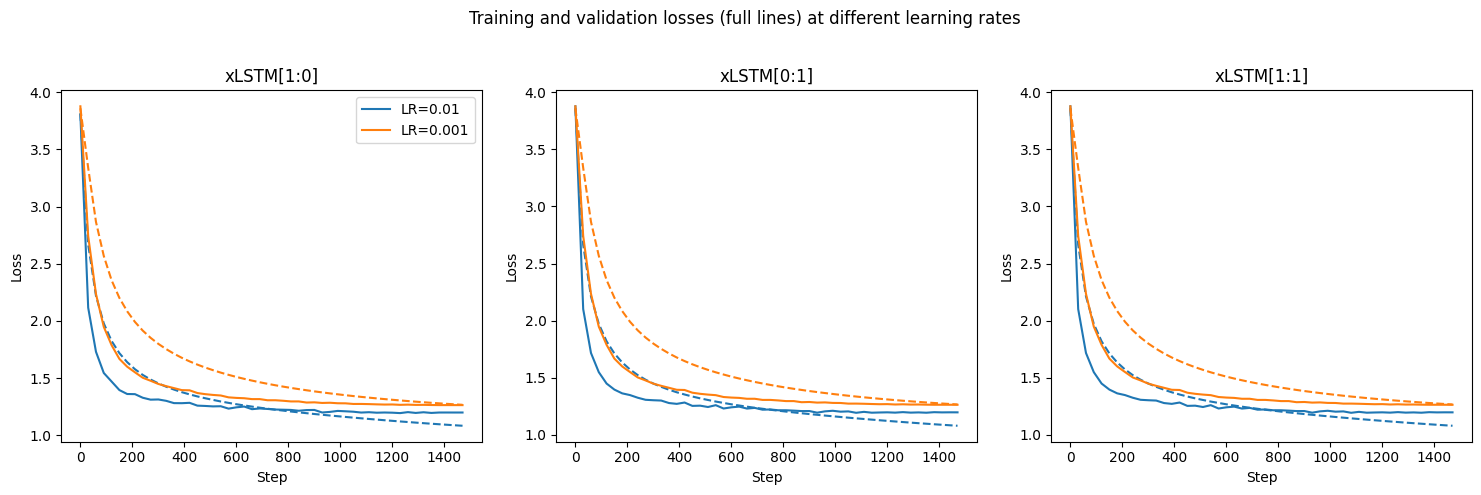

In [8]:
# VISUALIZE EXPERIMENTS

# 1 - Learning rates
database_name = cfg.database.name
db = ExperimentDatabase(db_name=database_name)
experiment_ids = [
    ["xLSTM[1:0]_learning_rate_1", "xLSTM[1:0]_learning_rate_2"],
    ["xLSTM[0:1]_learning_rate_3", "xLSTM[0:1]_learning_rate_4"],
    ["xLSTM[1:1]_learning_rate_5", "xLSTM[1:1]_learning_rate_6"]
]
title = "Training and validation losses (full lines) at different learning rates"
legend_text = "LR={config.training.lr}"
plot3_train_val_loss(title, experiment_ids, legend_text, db)

## Exercise 4: Utilizing a Pretrained Model (Bonus)

Foundation Models, those pretrained on large amounts of data are more and more important. We can use those models and fine-tune them on our dataset, rather then training them from scratch.
Here are the things to consider:

- Model Selection: Choose a pretrained language model from an online repository. Hint: You can explore platforms like Hugging Face (huggingface.co), which host numerous pretrained models.

- Dataset: Use the Trump dataset with the same training and validation split as in previous exercises. You do not need to use character tokenization.

- Performance Evaluation: Evaluate the performance of the pretrained model on the validation set before and during fine-tuning. Report average-CE-loss as well as an example generated sequence with the same prompt for each epoch.

- Fine-tuning: Adjust the learning rate, potentially freeze some layers, train for a few epochs with a framework of your choice (e.g. [lightning](https://lightning.ai/docs/pytorch/stable/), [huggingface](https://huggingface.co/models), ...)

- Computational Resources: Be mindful of the computational demands of pretrained models. You might need access to GPUs. Try to keep the model size at a minimum and go for e.g. distilled versions or other small LMs

- Hyperparameter Tuning: You can experiment with different learning rates and potentially other hyperparameters during fine-tuning but no need to do this in depth

By completing this exercise, you will gain experience with utilizing pretrained models, understanding their capabilities, and the process of fine-tuning. Decreasing the validation loss can be seen a success for this exercise.

> **Note**: This is a standalone exercise and doesn't build upon the previous tasks.

In [ ]:
########## SOLUTION BEGIN ##########

########## YOUR SOLUTION HERE ##########